In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import scipy.ndimage as ndi
import glob
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.feature import peak_local_max
from roifile import ROI_TYPE, ROI_OPTIONS, roiwrite
from roifile import ImagejRoi
import plotly.express as px
from scipy.stats import rankdata
import scipy as sp
import napari
import os
%gui qt5

In [2]:
viewer = napari.Viewer()

# Load images

In [3]:
fnames=glob.glob('10032022/*_realigned.tif')
#fnames.remove('merged_realigned.tif')

In [4]:
img=tifffile.imread(fnames[0])

In [5]:
imgs = [tifffile.imread(f) for f in fnames]

In [6]:
lst = []
for i in imgs:
    extras = 450 - i.shape[2]
    left = np.round(extras/2).astype(int)
    tmp = np.pad(i, ((0,0), (0,0), (left,extras-left), (0,0)))
    lst.append(tmp)

In [7]:
imgs = np.array(lst)

In [8]:
viewer.layers.clear()

In [9]:
viewer.add_image(np.max(imgs,axis=1), channel_axis=1)

[<Image layer 'Image' at 0x21adba33a30>,
 <Image layer 'Image [1]' at 0x21ac8b04a60>,
 <Image layer 'Image [2]' at 0x21ae9af4670>]

In [10]:
max_project = np.max(imgs,axis=1)
max_project.shape

(396, 3, 450, 60)

In [11]:
ptiles = np.percentile(max_project[:,0], 95, axis=[1,2], )
max_project[:,0] = max_project[:,0]/ptiles[:,np.newaxis,np.newaxis]*1000

In [12]:
viewer.layers.clear()

In [13]:
viewer.add_image(max_project, channel_axis=1)

[<Image layer 'Image' at 0x21adba95be0>,
 <Image layer 'Image [1]' at 0x21ae9c40ee0>,
 <Image layer 'Image [2]' at 0x21ae9d0b190>]

In [14]:
tifffile.imwrite('Aligned.tif', imgs.astype(np.ushort), imagej=True)

### Read just the 30th slice of the image stack. This is the slice that contains the center

In [15]:
#now read the 30th slice for every image
imgs=[tifffile.imread(fnames[i])[29,:,:,:] for i in range(len(fnames))]
imgs[252] = imgs[249]

In [16]:
imgs[0].shape

(3, 71, 60)

In [17]:
heights=[imgs[i].shape[1] for i in range(len(imgs))]
widths=[imgs[i].shape[2] for i in range(len(imgs))]
depths=[imgs[i].shape[0] for i in range(len(imgs))]

In [18]:
maxshape=[max(depths),max(heights),max(widths)]
print(maxshape)

[3, 118, 60]


In [19]:
def pasteCentered(img,outshape):
    #pastes and image centered on the output shape with linear interpolation
    #outimg=np.zeros(outshape,dtype=float)
    padvals=np.array(outshape)-np.array(img.shape)
    padvals2=[[0,padvals[i]] for i in range(len(padvals))]
    outimg=np.pad(img,padvals2,mode='constant')
    shifts=0.5*padvals
    print(shifts)
    return ndi.shift(outimg,shifts,output=float,order=2,mode='constant',cval=0.0)

In [20]:
shifted=np.array([pasteCentered(imgs[i],maxshape) for i in range(len(imgs))])

[ 0.  23.5  0. ]
[ 0. 26.  0.]
[ 0. 18.  0.]
[ 0.  26.5  0. ]
[ 0.  23.5  0. ]
[ 0.  11.5  0. ]
[ 0. 26.  0.]
[ 0. 17.  0.]
[ 0.  14.5  0. ]
[0. 0. 0.]
[0. 7. 0.]
[ 0.  10.5  0. ]
[ 0.  16.5  0. ]
[ 0.  14.5  0. ]
[ 0.  26.5  0. ]
[0. 5. 0.]
[ 0. 26.  0.]
[ 0. 12.  0.]
[ 0. 15.  0.]
[ 0. 40.  0.]
[ 0. 21.  0.]
[ 0. 11.  0.]
[ 0.  28.5  0. ]
[ 0. 13.  0.]
[ 0.  36.5  0. ]
[ 0. 38.  0.]
[ 0. 17.  0.]
[ 0.  15.5  0. ]
[0.  7.5 0. ]
[ 0.  22.5  0. ]
[ 0. 20.  0.]
[ 0. 15.  0.]
[0.  8.5 0. ]
[ 0. 14.  0.]
[ 0.  15.5  0. ]
[ 0. 23.  0.]
[0. 6. 0.]
[0. 4. 0.]
[0.  4.5 0. ]
[ 0.  28.5  0. ]
[0.  8.5 0. ]
[ 0.  20.5  0. ]
[ 0. 21.  0.]
[ 0. 32.  0.]
[ 0.  13.5  0. ]
[ 0. 23.  0.]
[ 0. 17.  0.]
[ 0.  14.5  0. ]
[ 0. 19.  0.]
[ 0.  19.5  0. ]
[ 0.  29.5  0. ]
[ 0. 23.  0.]
[ 0.  21.5  0. ]
[ 0. 27.  0.]
[ 0.  24.5  0. ]
[0.  3.5 0. ]
[0.  2.5 0. ]
[ 0. 31.  0.]
[ 0.  21.5  0. ]
[ 0. 24.  0.]
[ 0.  23.5  0. ]
[0. 7. 0.]
[ 0.  19.5  0. ]
[ 0.  28.5  0. ]
[ 0.  22.5  0. ]
[ 0. 17.  0.]
[ 0. 18.  0.]

In [21]:
shifted.shape

(396, 3, 118, 60)

In [22]:
viewer.layers.clear()
viewer.add_image(shifted, channel_axis=1)

[<Image layer 'Image' at 0x21ae9e3aee0>,
 <Image layer 'Image [1]' at 0x21ae9e32f40>,
 <Image layer 'Image [2]' at 0x21aece85f40>]

If there is an assymmetry to the image, reflet it so that the right side of the image has more intensity in the CenpB channel.

In [23]:
def flipper(inp):
    halfway=30
    left = inp[0,:,0:halfway].sum()
    right = inp[0,:,halfway:].sum()
    if right>left:
        return inp
    else:
        return np.flip(inp, axis=-1)

In [24]:
#shifted = np.array([flipper(a) for a in shifted])

ptiles = np.percentile(shifted[:,0], 95, axis=[1,2], )
shifted[:,0] = shifted[:,0]/ptiles[:,np.newaxis,np.newaxis]*1000

tifffile.imwrite('Aligned_Right.tif', shifted.astype(np.single), imagej=True)

### Look at average projections

In [25]:
#now average the images
merged_realigned_avg=shifted.mean(axis=0)
merged_realigned_avg.shape

(3, 118, 60)

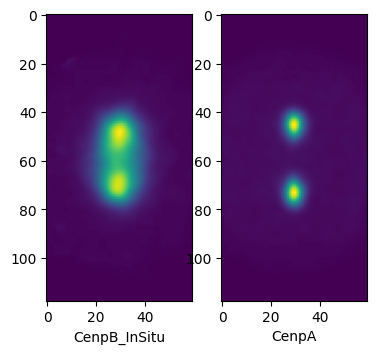

In [26]:
ax=plt.subplot(1,3,1)
ax.imshow(merged_realigned_avg[0])
ax.set_xlabel('CenpB_InSitu')
ax=plt.subplot(1,3,2)
ax.imshow(merged_realigned_avg[1])
ax.set_xlabel('CenpA')
tifffile.imwrite('Merged_Right.tif', merged_realigned_avg.astype(np.single), imagej=True, metadata={'axes':'CYX'})
plt.show()

In [27]:
#let's make a normalized central kymograph for cenpB
centerx=np.ceil(maxshape[2]/2).astype(int)
centery=np.ceil(maxshape[1]/2).astype(int)

def makeTProfile(arr,center,hwidth,chan,vert=False,norm=True,mirror=False):
    if(not vert):
        kym=np.array([arr[i,chan,(center-hwidth):(center+hwidth),:].sum(axis=0) for i in range(len(arr))])
        if(norm):
            sumprof=kym.sum(axis=1)
            kym/=np.expand_dims(sumprof,axis=1).repeat(kym.shape[1],axis=1)
        if(mirror):
            kym+=np.flip(kym,axis=1)
            kym*=0.5
    else:
        kym=np.array([arr[i,chan,:,(center-hwidth):(center+hwidth)].sum(axis=1) for i in range(len(arr))])
        if(norm):
            sumprof=kym.sum(axis=1)
            kym/=np.expand_dims(sumprof,axis=1).repeat(kym.shape[1],axis=1)
        if(mirror):
            kym+=np.flip(kym,axis=1)
            kym*=0.5
    return kym

In [28]:
lateral_kym=makeTProfile(arr=np.clip(shifted, 0,10000),center=centery,hwidth=2,chan=0,vert=False,norm=True,mirror=True)
lateral_kym2=makeTProfile(arr=np.clip(shifted, 0, 10000),center=centery,hwidth=20,chan=1,vert=False,norm=True,mirror=True)
vert_kym=makeTProfile(arr=np.clip(shifted, 0, 10000),center=centerx,hwidth=2,chan=0,vert=True,norm=True,mirror=True)
vert_kym2=makeTProfile(arr=np.clip(shifted, 0, 10000),center=centerx,hwidth=2,chan=1,vert=True,norm=True,mirror=True)

### Now look at un-evenness of distribution of CenpB

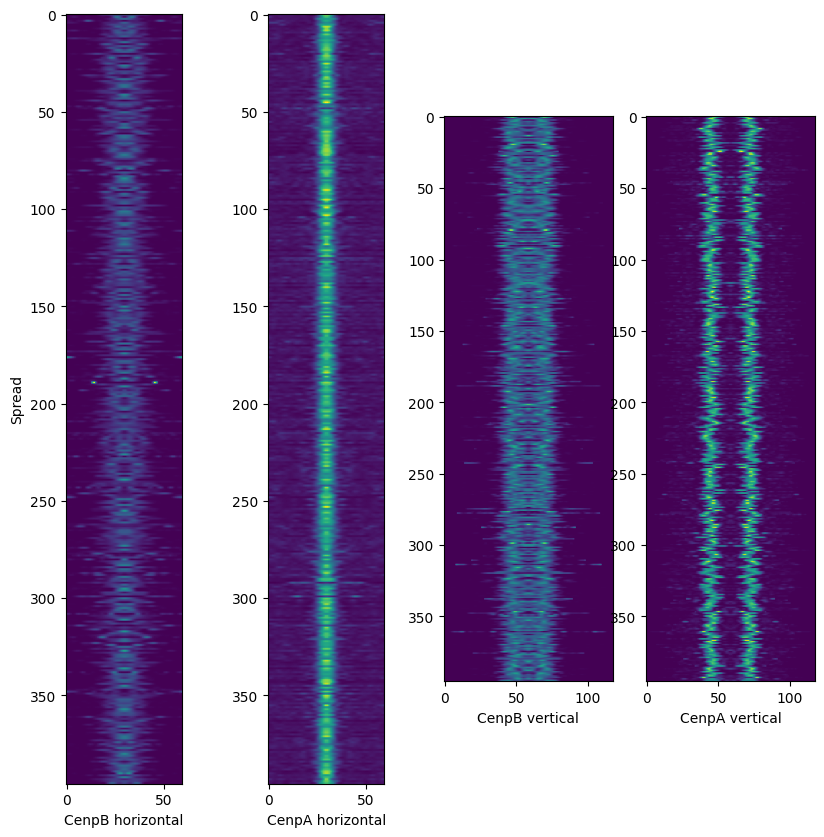

In [29]:
plt.figure(figsize=(10,10))
ax=plt.subplot(1,4,1)
ax.imshow(lateral_kym)
ax.set_xlabel('CenpB horizontal')
ax.set_ylabel('Spread')
ax=plt.subplot(1,4,2)
ax.imshow(lateral_kym2)
ax.set_xlabel('CenpA horizontal')
ax=plt.subplot(1,4,3)
ax.imshow(vert_kym)
ax.set_xlabel('CenpB vertical')
ax=plt.subplot(1,4,4)
ax.imshow(vert_kym2)
ax.set_xlabel('CenpA vertical')
plt.show()

In [30]:
#measure the intensity in the center vs. the edges and sort on that ratio
epos1=centerx-6
cratio=lateral_kym[:,(centerx-2):(centerx+2)].sum(axis=1)/lateral_kym[:,(epos1-3):(epos1+3)].sum(axis=1)
crorder=np.argsort(cratio)

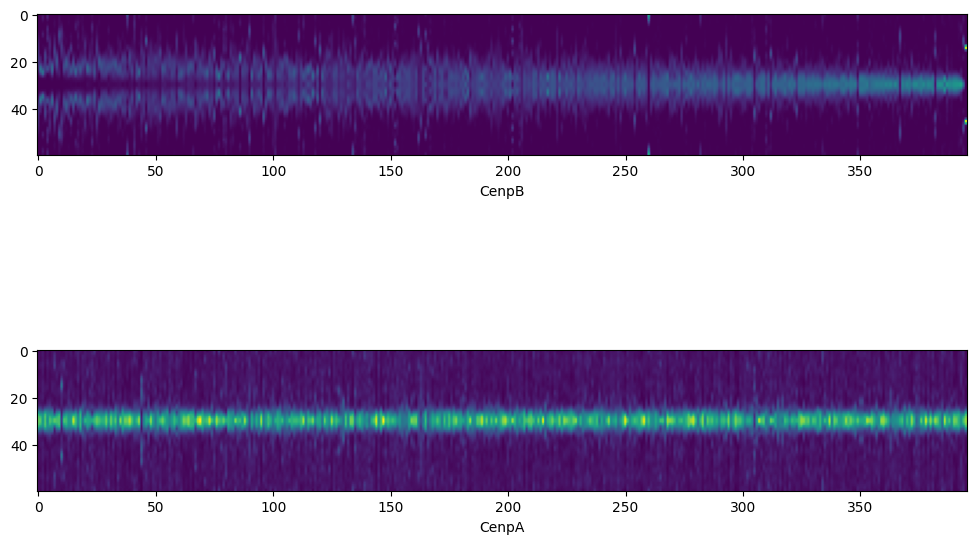

In [31]:
#show the sorted kymograph based on center/edge ratio
plt.figure(figsize=(12,8))
ax=plt.subplot(2,1,1)
ax.imshow(lateral_kym[crorder,:].T)
ax.set_xlabel("CenpB")
ax=plt.subplot(2,1,2)
ax.imshow(lateral_kym2[crorder,:].T)
ax.set_xlabel("CenpA")
plt.show()

### Show CenpA profile vs CenpB profile

In [34]:

xvals=31*(np.arange(vert_kym2.shape[1])-centery+.95)
tdf = pd.DataFrame({'Position (um)':xvals, 'CenpA':vert_kym2.sum(axis=0)/np.sum(vert_kym2),
                   'CenpB':vert_kym.sum(axis=0)/np.sum(vert_kym)})
#tdf.to_csv('CenpAvsCenpBv2_FISH.csv')
fig = px.line(tdf, x='Position (um)', y=['CenpA', 'CenpB'], range_x=[-1500,1500])
#fig.write_html('CenpAvsCenpB_FISHv2.html')
fig



# Fit curves

In [35]:
import plotly.express as px
import scipy.optimize as optimize



In [36]:
def gauss2(x, sigma1, center1, sigma2, center2,  a1, a2, c):
    return c+a1*np.exp(-1.0*((x-center1)**2)/2/sigma1/sigma1)+a2*np.exp(-1.0*((x-center2)**2)/2/sigma2/sigma2)


def gauss3(x, sigma1, center1, sigma2, center2, sigma3, center3, a1, a2, a3, c):
    return c+a1*np.exp(-1.0*((x-center1)**2)/2/sigma1/sigma1)+a2*np.exp(-1.0*((x-center2)**2)/2/sigma2/sigma2)+a3*np.exp(-1.0*((x-center3)**2)/2/sigma3/sigma3)



### CenpA

In [37]:
x = (np.arange(vert_kym.shape[1])-58.5)*31
params2 = optimize.curve_fit(gauss2, x, vert_kym2.sum(axis=0)/np.sum(vert_kym2), bounds=([0,-500,0,0,0,0,-1], [500,0,500,500,.2,.2,5]))[0]
tdf = pd.DataFrame({'X':x, 'Y':vert_kym2.sum(axis=0)/np.sum(vert_kym2), '2-Gaussian':gauss2(x, *params2)})
tdf.to_csv('Vertical_CenpA.csv')
title = 'Vertical CenpA with 2-Gaussian fit, centers:  {c1} and {c2}.  Widths:  {w1} and {w2}'.format(c1=params2[1], c2=params2[3], w1=params2[0], w2=params2[2])
f = px.line(tdf, x='X', y=['Y', '2-Gaussian'], title= title)
f.write_html('Vertical_CenpA.html')
f



### CenpB

In [39]:

x = 31*(np.arange(vert_kym2.shape[1])-58.5)
params3 = optimize.curve_fit(gauss3, x, vert_kym.sum(axis=0)/np.sum(vert_kym), bounds=([0,-500,0,-100,0,0,0,0,0,-1], [500,0,500,100,500,500,.2,.2,.2,5]))[0]
tdf = pd.DataFrame({'X':x, 'Y':vert_kym.sum(axis=0)/np.sum(vert_kym), '3-Gaussian':gauss3(x, *params3)})
#tdf.to_csv('Vertical_CenB.csv')
title = 'Vertical CenB with 3-Gaussian fit, centers:  {c1}, {c2}, and {c3}.  Widths:  {w1}, {w2}, and {w3}'.format(c1=params3[1], c2=params3[3], c3=params3[5], w1=params3[0], w2=params3[2], w3=params3[4])
f = px.line(tdf, x='X', y=['Y', '3-Gaussian'], title= title)
#f.write_html('Vertical_CenB.html')
f



# Look at subsets of CenpB

Clearly there are subsets of spreads that are split at the centromeres and constant through the centromeres and concentrated at the centromeres.  Let's look at those.

In [96]:
cutoffs = [0,120,275,950]

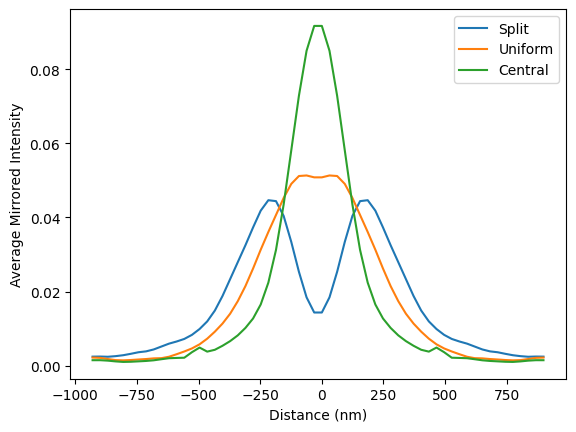

In [97]:
xvals=31.0*(np.arange(lateral_kym.shape[1])-centerx)
plt.plot(xvals,lateral_kym[crorder[cutoffs[0]:cutoffs[1]],:].mean(axis=0))
plt.plot(xvals,lateral_kym[crorder[cutoffs[1]:cutoffs[2]],:].mean(axis=0))
plt.plot(xvals,lateral_kym[crorder[cutoffs[2]:cutoffs[3]],:].mean(axis=0))
plt.legend(['Split','Uniform','Central'])
plt.xlabel('Distance (nm)')
plt.ylabel('Average Mirrored Intensity')
plt.show()

In [98]:
shifted.shape

(396, 3, 118, 60)

## Make images for split, uniform, central

### Split

In [99]:
split_realigned_avg=np.swapaxes(shifted[crorder[cutoffs[0]:cutoffs[1]]].mean(axis=0),1,2)
f = px.imshow(split_realigned_avg[0], y=(np.arange(0,60)-30)*31, x=(np.arange(0,118)-58.5)*31, title='CenpB Split')
f.write_image('CenpB_Split.pdf')
f

In [100]:
split_realigned_avg=np.swapaxes(shifted[crorder[cutoffs[0]:cutoffs[1]]].mean(axis=0),1,2)
f = px.imshow(split_realigned_avg[1], y=(np.arange(0,60)-30)*31, x=(np.arange(0,118)-58.5)*31, title='CenpA Split')
f.write_image('CenpA_Split.pdf')
f

In [101]:
split_realigned_avg=np.swapaxes(shifted[crorder[cutoffs[0]:cutoffs[1]]].mean(axis=0),1,2)
f = px.imshow(split_realigned_avg[2], y=(np.arange(0,60)-30)*31, x=(np.arange(0,118)-58.5)*31, title='DAPI Split')
f.write_image('DAPI_Split.pdf')
f

### Uniform

In [102]:
uni_realigned_avg=np.swapaxes(shifted[crorder[cutoffs[1]:cutoffs[2]]].mean(axis=0),1,2)
f = px.imshow(uni_realigned_avg[0], y=(np.arange(0,60)-30)*31, x=(np.arange(0,118)-58.5)*31, title='CenpB Uniform')
f.write_image('CenpB_Uniform.pdf')
f

In [103]:
uni_realigned_avg=np.swapaxes(shifted[crorder[cutoffs[1]:cutoffs[2]]].mean(axis=0),1,2)
f = px.imshow(uni_realigned_avg[1], y=(np.arange(0,60)-30)*31, x=(np.arange(0,118)-58.5)*31, title='CenpA Uniform')
f.write_image('CenpA_Uniform.pdf')
f

In [104]:
uni_realigned_avg=np.swapaxes(shifted[crorder[cutoffs[1]:cutoffs[2]]].mean(axis=0),1,2)
f = px.imshow(uni_realigned_avg[2], y=(np.arange(0,60)-30)*31, x=(np.arange(0,118)-58.5)*31, title='DAPI Uniform')
f.write_image('DAPI_Uniform.pdf')
f

### Central

In [105]:
central_realigned_avg=np.swapaxes(shifted[crorder[cutoffs[2]:cutoffs[3]]].mean(axis=0),1,2)
f = px.imshow(central_realigned_avg[0], y=(np.arange(0,60)-30)*31, x=(np.arange(0,118)-58.5)*31, title='CenpB Central')
f.write_image('CenpB_Central.pdf')
f

In [106]:
central_realigned_avg=np.swapaxes(shifted[crorder[cutoffs[2]:cutoffs[3]]].mean(axis=0),1,2)
f = px.imshow(central_realigned_avg[1], y=(np.arange(0,60)-30)*31, x=(np.arange(0,118)-58.5)*31, title='CenpA Central')
f.write_image('CenpA_Central.pdf')
f

In [107]:
central_realiagned_avg=np.swapaxes(shifted[crorder[cutoffs[2]:cutoffs[3]]].mean(axis=0),1,2)
f = px.imshow(central_realiagned_avg[2], y=(np.arange(0,60)-30)*31, x=(np.arange(0,118)-58.5)*31, title='DAPI Central')
f.write_image('DAPI_Central.pdf')
f

### Do Gaussian fits for central and split (33 percentile and 66 percentile) FOR VERTICAL

In [108]:
#measure the intensity in the center vs. the edges and sort on that ratio
epos1=centery-6
cratio=vert_kym[:,(centery-2):(centery+2)].sum(axis=1)/vert_kym[:,(epos1-3):(epos1+3)].sum(axis=1)
crorder=np.argsort(cratio)

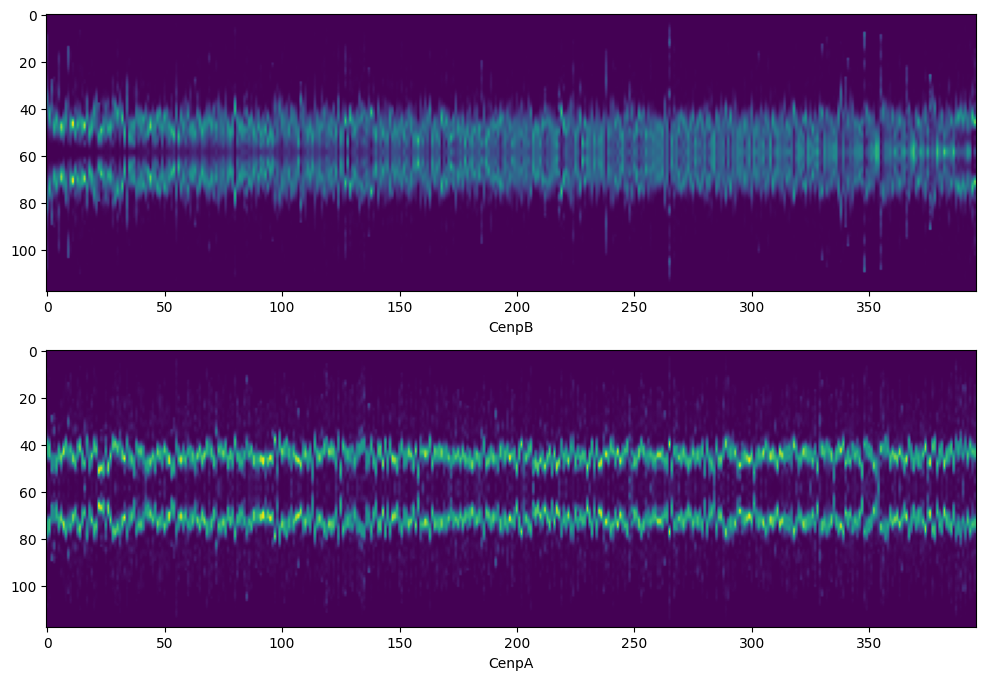

In [109]:
#show the sorted kymograph based on center/edge ratio
plt.figure(figsize=(12,8))
ax=plt.subplot(2,1,1)
ax.imshow(vert_kym[crorder,:].T)
ax.set_xlabel("CenpB")
ax=plt.subplot(2,1,2)
ax.imshow(vert_kym2[crorder,:].T)
ax.set_xlabel("CenpA")
plt.show()

In [110]:
cutoffs = [0,132,264,950]

In [111]:
tifffile.imwrite('Sorted_Vertical.tif', shifted[crorder].astype(np.single), imagej=True, metadata={'axes':'TCYX'})
#tifffile.imwrite('UnSorted_Vertical.tif', shifted[np.random.choice(crorder, len(crorder), replace=False)].astype(np.single), imagej=True, metadata={'axes':'TCYX'})



In [112]:
xvals = (np.arange(vert_kym.shape[1])-58.5)*31

In [113]:
tdf = pd.DataFrame({'X':xvals, 'Split':vert_kym2[crorder[cutoffs[0]:cutoffs[1]],:].mean(axis=0), 'Central':vert_kym2[crorder[cutoffs[2]:cutoffs[3]],:].mean(axis=0)})
f = px.line(tdf, x='X', y=['Split', 'Central'], title='CenpA in Split and Central CenpB Classes', labels={'variable':'Class'})
f.write_html('CenpAVerticalSeparatedByCenpBClasses.html')
f

In [115]:
tdf = pd.DataFrame({'X':xvals, 'Split':vert_kym[crorder[cutoffs[0]:cutoffs[1]],:].mean(axis=0), 'Central':vert_kym[crorder[cutoffs[2]:cutoffs[3]],:].mean(axis=0)})
f = px.line(tdf, x='X', y=['Split', 'Central'], title='CenpB in Split and Central CenB Classes', labels={'variable':'Class'})
f.write_html('CenBVerticalSeparatedByCenBClasses.html')
f

In [117]:
def gauss2(x, sigma1, center1, sigma2, center2, a, b, c):
    return c+a*np.exp(-1.0*((x-center1)**2)/2/sigma1/sigma1)+b*np.exp(-1.0*((x-center2)**2)/2/sigma2/sigma2)

x = (np.arange(vert_kym.shape[1])-58.5)*31
y = vert_kym2[crorder[cutoffs[0]:cutoffs[1]],:].mean(axis=0)
params2 = optimize.curve_fit(gauss2, x, y, bounds=([0,-500,0,0,0,0,-1], [500,0,500,500,.2,.2,5]))[0]
tdf = pd.DataFrame({'X':x, 'Y':y, '2-Gaussian':gauss2(x, *params2)})
tdf.to_csv('Vertical_CenpA_edges.csv')
title = 'Vertical CenpA with 2-Gaussian fit, CenpB separated, centers:  {c1} and {c2}.  Widths:  {w1} and {w2}'.format(c1=params2[1], c2=params2[3], w1=params2[0], w2=params2[2])
f = px.line(tdf, x='X', y=['Y', '2-Gaussian'], title= title)
f.write_html('Vertical_CenpA_edges.html')
f

In [118]:
def gauss2(x, sigma1, center1, sigma2, center2, a, b, c):
    return c+a*np.exp(-1.0*((x-center1)**2)/2/sigma1/sigma1)+b*np.exp(-1.0*((x-center2)**2)/2/sigma2/sigma2)

x = (np.arange(vert_kym.shape[1])-58.5)*31
y = vert_kym2[crorder[cutoffs[2]:cutoffs[3]],:].mean(axis=0)
params2 = optimize.curve_fit(gauss2, x, y, bounds=([0,-500,0,0,0,0,-1], [500,0,500,500,.2,.2,5]))[0]
tdf = pd.DataFrame({'X':x, 'Y':y, '2-Gaussian':gauss2(x, *params2)})
tdf.to_csv('Vertical_CenpA_centered.csv')
title = 'Vertical CenpA with 2-Gaussian fit, CenpB centered, centers:  {c1} and {c2}.  Widths:  {w1} and {w2}'.format(c1=params2[1], c2=params2[3], w1=params2[0], w2=params2[2])
f = px.line(tdf, x='X', y=['Y', '2-Gaussian'], title= title)
f.write_html('Vertical_CenpA_centered.html')
f

# END USEFUL CODE

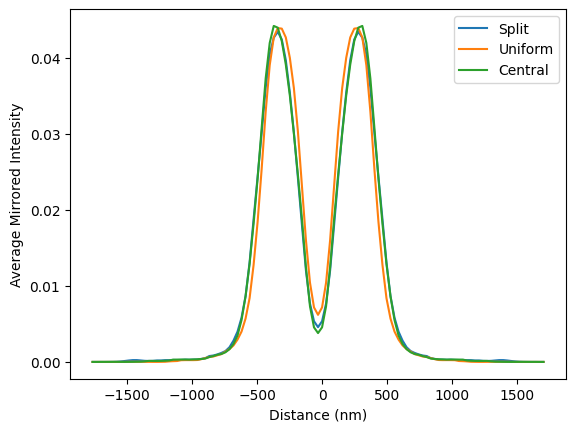

In [95]:
xvals=31.0*(np.arange(vert_kym2.shape[1])-centery)
plt.plot(xvals,vert_kym2[crorder[cutoffs[0]:cutoffs[1]],:].mean(axis=0))
plt.plot(xvals,vert_kym2[crorder[cutoffs[1]:cutoffs[2]],:].mean(axis=0))
plt.plot(xvals,vert_kym2[crorder[cutoffs[2]:cutoffs[3]],:].mean(axis=0))
plt.legend(['Split','Uniform','Central'])
plt.xlabel('Distance (nm)')
plt.ylabel('Average Mirrored Intensity')
plt.show()

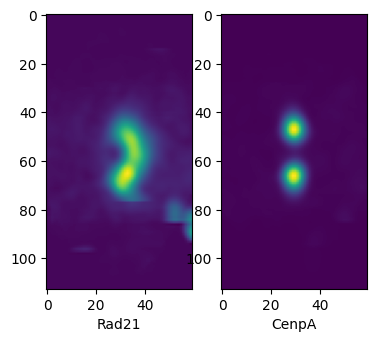

In [96]:
#now make average images for the sorted datasets
#start with the split species
split_realigned_avg=shifted[crorder[cutoffs[0]:cutoffs[1]]].mean(axis=0)
ax=plt.subplot(1,3,1)
ax.imshow(split_realigned_avg[0])
ax.set_xlabel('Rad21')
ax=plt.subplot(1,3,2)
ax.imshow(split_realigned_avg[1])
ax.set_xlabel('CenpA')
plt.show()

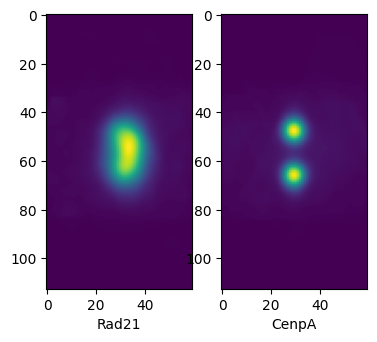

In [65]:
#now the uniform species
uni_realigned_avg=shifted[crorder[cutoffs[1]:cutoffs[2]]].mean(axis=0)
ax=plt.subplot(1,3,1)
ax.imshow(uni_realigned_avg[0])
ax.set_xlabel('Rad21')
ax=plt.subplot(1,3,2)
ax.imshow(uni_realigned_avg[1])
ax.set_xlabel('CenpA')

plt.show()

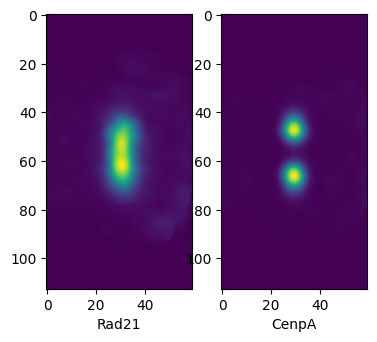

In [66]:
#and finally the central species
cen_realigned_avg=shifted[crorder[cutoffs[2]:cutoffs[3]]].mean(axis=0)
ax=plt.subplot(1,3,1)
ax.imshow(cen_realigned_avg[0])
ax.set_xlabel('Rad21')
ax=plt.subplot(1,3,2)
ax.imshow(cen_realigned_avg[1])
ax.set_xlabel('CenpA')
plt.show()

In [67]:
tifffile.imwrite('Type_Split.tif', split_realigned_avg.astype(np.single), imagej=True)
tifffile.imwrite('Type_Uniform.tif', uni_realigned_avg.astype(np.single), imagej=True)
tifffile.imwrite('Type_Center.tif', cen_realigned_avg.astype(np.single), imagej=True)
tifffile.imwrite('Type_All.tif', shifted.mean(axis=0).astype(np.single), imagej=True)
tifffile.imwrite('Kymographs.tif', lateral_kym[crorder,:].T.astype(np.single), imagej=True)
tifffile.imwrite('Aligned_Ordered.tif', shifted[crorder].astype(np.single), imagej=True)

# REST NOT USED

# Build images with rank as a channel

In [50]:
from roifile import ImagejRoi
import plotly.express as px

In [51]:
df = pd.DataFrame({'File':fnames, 'Ratio':cratio, 'Rank':(crorder/np.max(crorder))})

In [52]:
root_dir = 'raw/'

In [53]:
df['ShortFile'] = df['File'].str.split('\\').str[-1].str.split('-').str[0] + '.tif'

In [54]:
df['Index'] = df['File'].str.split('\\').str[-1].str.split('-').str[1].str.split('_').str[0]
df['Index'] = df['Index'].apply(lambda a: ''.join(x for x in a if x.isdecimal()))

In [55]:
f = px.box(df, x='ShortFile', y='Ratio', points='all')
f.write_html('RankByFile.html')
f

In [56]:
roi_files = glob.glob(root_dir+'*.zip')
roi_files

[]

In [57]:
df

File     Ratio      Rank         ShortFile  \
0     SIM\Image 14_SIM-1._realigned.tif  0.087106  0.823810  Image 14_SIM.tif   
1    SIM\Image 14_SIM-10._realigned.tif  0.113103  0.419048  Image 14_SIM.tif   
2    SIM\Image 14_SIM-11._realigned.tif  2.087862  0.717460  Image 14_SIM.tif   
3    SIM\Image 14_SIM-12._realigned.tif  1.587921  0.661905  Image 14_SIM.tif   
4    SIM\Image 14_SIM-13._realigned.tif  0.120852  0.725397  Image 14_SIM.tif   
..                                  ...       ...       ...               ...   
626   SIM\Image 27_SIM-5._realigned.tif  0.376296  0.093651  Image 27_SIM.tif   
627   SIM\Image 27_SIM-6._realigned.tif  0.473230  0.911111  Image 27_SIM.tif   
628   SIM\Image 27_SIM-7._realigned.tif  0.311777  0.506349  Image 27_SIM.tif   
629   SIM\Image 27_SIM-8._realigned.tif  0.619343  0.777778  Image 27_SIM.tif   
630   SIM\Image 27_SIM-9._realigned.tif  0.132632  0.546032  Image 27_SIM.tif   

    Index  
0       1  
1      10  
2      11  
3      12  
4      13  
..    ...  
626     5  
627     6  
628     7  
629     8  
630     9  

[631 rows x 5 columns]

In [58]:
import scipy as sp


In [59]:
viewer = napari.Viewer()

In [60]:
for rfile in roi_files:
    rois = ImagejRoi.fromfile(rfile)
    short_file = rfile.split('\\')[-1].split('.')[0]+'.tif'
    tfile = root_dir+short_file
    print(short_file)
    img = tifffile.imread(tfile)
    timg = np.zeros([img.shape[0], 2, img.shape[2], img.shape[3]])
    flipper = 0
    for ct, roi in enumerate(rois):
        tmp = np.max([roi.position, roi.counter_positions[0]])
        zpos = -1
        if tmp == roi.position:
            zpos = roi.position
        else:
            zpos = int(np.floor(roi.counter_positions[0]/(img.shape[1])) + 1 )
            #zpos = roi.counter_positions[0]
        x = int(roi.coordinates()[0][0])
        y = int(roi.coordinates()[0][1])
        z = int(zpos-1)
        df_index = int(np.floor((ct)/2)) + 1
        mask = (df['ShortFile']==short_file) & (df['Index'].astype(int)==df_index)
        tdf = df[mask]
        if flipper==0:
            df.loc[mask, 'X1'] = x
            df.loc[mask, 'Y1'] = y
            df.loc[mask, 'Z1'] = z
            flipper = 1
        else:
            df.loc[mask, 'X2'] = x
            df.loc[mask, 'Y2'] = y
            df.loc[mask, 'Z2'] = z
            flipper = 0
        
        print([x,y,z])
        print(timg.shape)
        timg[z,0,y,x] = tdf['Rank'].max()
        timg[z,1,y,x] = tdf['Ratio'].max()
    timg = sp.ndimage.maximum_filter(timg, size = [4,0,15,15])
    timg = np.concatenate([img, timg], axis=1)
    tifffile.imsave('ranked_projections/'+short_file, np.max(timg, axis=0).astype(np.single), imagej=True)


In [61]:
viewer.add_image(np.max(timg, axis=0), channel_axis=0)

NameError: name 'timg' is not defined

In [ ]:
print(img.shape)

In [ ]:
roi.counter_positions[0]

# Alternative Peak Finding

In [ ]:
def find_peaks(img, threshold=0.1, display=False):
    LoG = -sp.ndimage.gaussian_laplace(img, sigma=[1,2,2])
    max_peaks = peak_local_max(LoG, indices=True, min_distance=3, threshold_rel=threshold)
    
    if display:
        viewer.add_image(LoG, blending='additive', colormap='magenta')
        viewer.add_points(max_peaks, n_dimensional=True, size=6)
    return max_peaks

In [ ]:
def pair_finder(peaks, min_dist=2, scale=[0.12, 0.04, 0.04]):
    scaled_peaks = peaks.copy().astype(float)
    scaled_peaks[:,0] = scaled_peaks[:,0] * scale[0]
    scaled_peaks[:,1] = scaled_peaks[:,1] * scale[1]
    scaled_peaks[:,2] = scaled_peaks[:,2] * scale[2]
    
    d_matrix = sp.spatial.distance.squareform(sp.spatial.distance.pdist(scaled_peaks))
    d_matrix[d_matrix==0] = 10000
    
    min_pos = np.argmin(d_matrix, axis=0)
    distances = np.min(d_matrix, axis=0)
    sorte = np.argsort(distances)
    
    lst = []
    for a in np.arange(0,len(sorte)):
        if distances[sorte[a]]<min_dist:
            if any([all (peaks[sorte[a]]==b) for b in lst]) | any([all(peaks[min_pos][sorte[a]]==b) for b in lst]):
                lst
            elif np.abs(peaks[sorte[a]][0]-peaks[min_pos][sorte[a]][0])>3:
                lst
            else:
                lst.append(peaks[sorte[a]])
                lst.append(peaks[min_pos][sorte[a]])
    return lst


In [ ]:
def find_peaks_in_file(fname, display=False):
    img = tifffile.imread(fname)
    if (display):
        viewer.add_image(img, channel_axis=1)
        
    peaks = find_peaks(img[:,1,:,:], threshold=0.1, display=display)
    filtered_peaks = pair_finder(peaks, min_dist=0.8, scale=[0.12, 0.04, 0.04])
    
    if (display):
        viewer.add_points(filtered_peaks, n_dimensional=True, size=6)
    rois = []
    for pt in filtered_peaks:
        roi = ImagejRoi.frompoints([[pt[2],pt[1]]], z=(pt[0]), name='X'+str(pt[1]))
        roi.roitype = ROI_TYPE.POINT
        roi.options = ROI_OPTIONS.SHOW_LABELS
        rois.append(roi)
    zip_file = fname[0:-4]+'.zip'
    if os.path.exists(zip_file):
        os.remove(zip_file)
    roiwrite(zip_file, rois)

In [ ]:
fnames = glob.glob('raw/*.tif')

In [ ]:
for f in glob.glob('raw/*.tif'):
    find_peaks_in_file(f)